# Object Detection for 2 Fruit Classification

The primary goal of this project is to build an object detection system capable of identifying and locating fruits, specifically Orange and Pomegranate, in images. The model aims to draw bounding boxes around the detected objects and classify them into one of two classes: 'Orange' and 'Pomegranate'. We must mention that because we are using Faster R-CNN method we have in total 3 classes. The extra class is for the background. 


### Model Architecture:
We employed a pre-trained Faster R-CNN model and fine-tuned it for our specific task. Faster R-CNN is a well-established architecture in the field of object detection, providing a good trade-off between speed and accuracy.


### Data Preparation:
The dataset comprises a variety of images containing oranges, pomegranates, and background scenes. Each image in the training and validation set is annotated with bounding boxes and labels indicating the type of fruit.

### Training:
The model was trained using a GPU, which allowed for faster computation and the ability to train on a large dataset. Several performance metrics such as loss, precision, and recall were monitored during the training process to fine-tune the model.

### Validation:
The performance of the trained model is validated using a separate dataset. Each prediction made by the model on the validation dataset is compared against the ground truth to calculate key metrics such as precision, recall and F1-Score. The Intersection over Union (IoU) metric is used to determine the accuracy of the bounding boxes predicted by the model.

### Evaluation Metrics:
We manually computed the precision, recall and F1-Score metrics to gauge the model's effectiveness. Precision gives us an indication of how many of the detected objects are relevant (true positives), while recall tells us how many of the actual objects were detected by the model.

### Visual evaluation:
Upon meticulous examination of both the validation and test datasets—which include previously unseen data—the model demonstrates commendable performance. For both oranges and pomegranate, the visual results are outstanding, with high-confidence bounding boxes closely aligning with the actual contours of the fruit. This suggests that the model is not only reliable but also exceptionally accurate when it comes to identifying and localizing the two fruits.

### Results:
Our object detection model presents a contrasting performance profile when evaluated using numerical metrics versus visual inspection. The model attained a moderate precision rate of 25% but struggled with a notably low recall rate of 2.05%, leading to a less-than-ideal F1 score of 0.037 with IoU threshold of 0.4. Interestingly, when the IoU threshold was reduced to 20%, precision surged to 86.9% while recall inched up to around 6.8%, resulting in an F1 score of 0.126. Despite these seemingly low performance indicators, visual inspection told a more optimistic story. The model demonstrated high proficiency in identifying both fruits.

These disparities point to possible areas of refinement. The low recall may be influenced by the limited number of bounding boxes considered in our evaluation, potentially neglecting correct but lower-ranked predictions. While the model performs excellently in detecting both in orange and pomegranate, it could benefit from further tuning. Overall, our initial results suggest that the model is a promising starting point for object detection in fruit, but it necessitates further adjustments to align its numerical evaluation metrics with its apparent visual successes.



## First we will Install and import necessary libraries

In [1]:
# Installing pycocotools
!pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Importing Necessary Libraries:

# For data manipulation and mathematical operations
import numpy as np

# For visualization
import matplotlib.pyplot as plt

# For file and folder operations
import os

# For image processing
import cv2

# For handling JSON files (commonly used for storing annotations in object detection)
import json

# For handling COCO dataset
from pycocotools.coco import COCO

# For deep learning and neural networks
import torch
import torchvision

# For loading pretrained Faster R-CNN model and modifying it
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# For loading COCO dataset
from torchvision.datasets import CocoDetection

# For data transformations
import torchvision.transforms as T
import torchvision.transforms as transforms

# For loading data
from torch.utils.data import DataLoader, Subset
from torch.utils.data import DataLoader, Dataset

#For pre-trained models from torchvision
import torchvision.models as models
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn

#For seed
import random

#For plotting
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

#For test images plot
import matplotlib.patches as patches

## Next we will define transformations: The goal is to convert images to PyTorch tensors

In [3]:
# We will convert image to PyTorch tensor
transform = transforms.Compose([transforms.ToTensor(),])

## Initialize COCO Dataset

### Parameters:

root: Path to the directory where images are stored

annFile: Path to the annotation file (in COCO format)

transform: The transformation pipeline to apply to the dataset images

In [4]:
# We will create dataset instance
dataset = CocoDetection(root=r"train",
                        annFile=r"train\results.json", 
                        transform=transform)



loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


## Initialize COCO Dataset for Validation

### Parameters:

root: Path to the directory where validation images are stored

annFile: Path to the annotation file for validation (in COCO format)

transform: The transformations to apply to the images

In [5]:
root_path = r"val"
ann_file_path = r"val\results.json"

val_dataset = CocoDetection(
    root=root_path,         
    annFile=ann_file_path,  
    transform=transform
)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


# Loading training and validation data
1. First we have to define the batch size which is the number of samples that will be loaded and processed before each update during training

2. Then we will have to create the DataLoader for training and validation data. The Dataloader automates the process of loading batches of images and corresponding labels during training

The parameters that we need for the Dataloaders are:

dataset: The dataset we want to load data from

batch_size: The size of the batches the data should be loaded in

shuffle: Whether to shuffle the data or not

num_workers: Number of subprocesses to use for data loading

collate_fn: Merges a list of samples to form a mini-batch of Tensor(s)

In [6]:
# We will define the batch size for training
batch_size = 4

# We will create DataLoader for training data
data_loader = DataLoader(dataset, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=0,  
                         collate_fn=lambda x: tuple(zip(*x)))  

In [7]:
# Here we define the batch size and the DataLoader for the validation dataset
val_batch_size = 1  

val_data_loader = DataLoader(val_dataset, 
                             batch_size=val_batch_size,
                             num_workers=0,  
                             collate_fn=lambda x: tuple(zip(*x)))  

## Now we will load a pretrained Faster R-CNN model with a ResNet-50-FPN backbone
For that we need to define the number of classes that we have. In our case we have 3 classes (0: Background, 1: Orange, 2: Pomegranate)

In [8]:
# We will load the pre-trained model
model = models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# We define the number of classes, which are 3 as mentioned above
num_classes = 3 

# We extract the number of input features from the classifier part of the model
in_features = model.roi_heads.box_predictor.cls_score.in_features

# We replace the existing box predictor with a new one that has the correct number of output classes (num_classes)
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


## Next we will freeze the layers and unfreeze only the final layer.
Freezing the layers of a pre-trained model is done so that the initial layers, which often capture generic features, remain the same. Only the final layers, which we usually replace for our specific task, will be trained.So we will unfreeze the last Layer. This is a common fine-tuning technique. For fine-tuning, we will enable gradient updates for the last classification layer and the bounding box regression layer. This will let us tailor the model to our specific task.

In [9]:
# freeze layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last classification layer
for param in model.roi_heads.box_predictor.cls_score.parameters():
    param.requires_grad = True

# Unfreeze the bounding box regression layer
for param in model.roi_heads.box_predictor.bbox_pred.parameters():
    param.requires_grad = True



## We will now create the optimizer by using Stochastic Gradient Descent (SGD)
We'll use SGD as our optimizer to update the weights of the model during training for its effectiveness and efficiency. We're only updating the parameters where 'requires_grad' is True (i.e., the unfrozen layers).

In [10]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


## Now we will create the function transform_targets which is designed to process the target annotations in our dataset.
This function extracts the bounding box coordinates and category labels from the target dictionary, and then it transforms the bounding box format

In [11]:
def transform_targets(targets):
    boxes = [item['bbox'] for item in targets]
    labels = [item['category_id'] for item in targets]
    
    # Convert the bounding boxes into [x1, y1, x2, y2] format (This is the format we have in our COCO annotation file)
    boxes = [[box[0], box[1], box[0] + box[2], box[1] + box[3]] for box in boxes]
    return {"boxes": torch.tensor(boxes, dtype=torch.float32), "labels": torch.tensor(labels, dtype=torch.int64)}

## Training Process

We trained our model for a total of two epochs, as preliminary results showed minimal training loss, reducing the risk of overfitting with additional training cycles. The loss values were 0.244 and 0.194 for the first and second epochs, respectively. While training on a dataset of 8,064 images, it took approximately 58,865 seconds (around 16,5 hours) to complete the entire training process.

To ensure the reproducibility of our results and for comparison with alternative models or configurations, we have also set a specific random seed before initiating the training.

Here are the detailed metrics:

Epoch 0: Training Loss = 0.244

Epoch 1: Training Loss = 0.194

Total Training Time: 58,865 seconds (approximately 16,5 hours)

By keeping the training limited to two epochs, we aim to achieve a well-generalized model while minimizing the risk of overfitting.

In [42]:
import time
# We will set a seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

#We set the epoch value first
num_epochs = 2 

# We start recording the time
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        targets = [transform_targets(target) for target in targets]
        loss_dict = model(images, targets)
        
        
        total_loss = sum(loss for loss in loss_dict.values())

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        total_loss.backward()

        # Update weights
        optimizer.step()

    # We will calculate and print the training loss for the epoch
    print(f"Epoch {epoch}/{num_epochs} Training Loss: {total_loss.item()}")

# Record the end time
end_time = time.time()

# Calculate and print the total time taken
total_time = end_time - start_time
print(f"Total time taken for training: {total_time} seconds")

Epoch 0/2 Training Loss: 0.24456324587145237
Epoch 1/2 Training Loss: 0.19475892354815244
Total time taken for training: 58865.65895471253 seconds


# Save the model

For further analysis we need to save our model first

In [13]:
model_save_path = r"training_model\model_name"
torch.save(model.state_dict(), model_save_path)


# We load the model

After saving our model we need to load it so we can use it.

In [31]:
# 1. First we define the model architecture
model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 3 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# 2. Then we load the saved model parameters
model.load_state_dict(torch.load(r"training_model\model_name"))

# 3.Finally we set the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# Evaluating Model Performance on a Separate Validation Dataset.

To rigorously assess the performance and generalizability of our object detection model, we will utilize a separate validation dataset. This dataset, referred to as val, contains a total of 1,008 images complete with their corresponding annotations.We will evaluate our model with 2 methods:

1.  Quantitative Metrics: We will also compute key performance metrics like precision, recall, and F1-score to quantitatively evaluate the model's detection capabilities.

2. Visual Inspection: We will run our model on the validation dataset and visually inspect some of the resulting bounding boxes in some of the images in the dataset to qualitatively assess the model's performance.


# Evaluation based on Quantitative Metrics:

## First we will implement the Validation Loop with Image Identifiers

In order to rigorously evaluate our object detection model, we incorporate a validation loop that also keeps track of image identifiers (image_id). This enables us to trace back each prediction to its corresponding image in the validation set, thereby facilitating a more granular analysis.

Once we've completed the initial setup, including loading the validation data and setting our model to evaluation mode, the next step is to actually evaluate the model on this validation dataset. This is a crucial step to understand how well the trained model generalizes to new, unseen data. So in order to do that we will create a list to store the model predictions and then we iterate through the validation DataLoader and for each batch of images and corresponding targets in val_data_loader we make predictions which are stored in all_model_outputs. The below needs approximately 3 hours to run because if its complexity and the datasets size.

In [15]:
#Validation loop
# We start by recording the start time
start_time = time.time()

# We set a seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# We set our model in evaluation mode
model.eval()

#We set the loop for the predictions in the val dataset
all_predictions = []
with torch.no_grad():
    for images, targets in val_data_loader:  
        predictions = model(images)

        # We extract image_ids from the targets dictionary
        image_ids = []
        for t in targets:
            for items in t:
                image_id = items['image_id']
                image_ids.append(image_id)
                
        # We add image_id to each prediction
        for pred, img_id in zip(predictions, image_ids):
            pred['image_id'] = img_id
            all_predictions.append(pred)
            
# We record the end time
end_time = time.time()

# We finally calculate the total time taken in seconds
total_time_seconds = end_time - start_time

## Now we will filter Predictions to Match Ground Truth Data
Before proceeding with the model evaluation, it's vital to ensure that the predicted results are directly comparable to the ground truth data. This practice ensures the calculated metrics are both robust and interpretable.

### Reformatting Predictions to COCO Format
First, we transform all predictions into the COCO format, which is a standardized JSON format used for object detection tasks. The code iterates over each prediction and extracts relevant details—bounding box coordinates, associated labels, and prediction confidence scores.

In [16]:
# creating the correct format for the PREDICTIONS!
coco_results_predictions = []

for image_id, prediction in enumerate(all_predictions):
    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        entry = {
            "image_id": image_id,  # Assuming a sequential image_id for simplicity
            "category_id": int(label),
            "bbox": [float(b) for b in box],  # COCO format: [x, y, width, height]
            "score": float(score)
        }
        coco_results_predictions.append(entry)

In [17]:
coco_gt = COCO(r"val\results.json")

# remove image ids that we do not need. this is for the prediction
annsImgIds = [ann['image_id'] for ann in coco_results_predictions]

extra_image_ids_in_predictions = set(annsImgIds) - set(coco_gt.getImgIds())
print("Extra image IDs in predictions:", extra_image_ids_in_predictions)


loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
Extra image IDs in predictions: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104, 105, 106, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 213, 214, 215, 216, 21

### Filtering Out Irrelevant Predictions
Next, we remove any predictions that do not correspond to image IDs present in our ground truth dataset. This step ensures that our evaluation metrics will only be calculated using predictions that have corresponding ground truth annotations.

In [18]:
filtered_predictions = [ann for ann in all_predictions if ann['image_id'] not in extra_image_ids_in_predictions]
filtered_predictions

[{'boxes': tensor([[2.1549e-01, 1.1089e+02, 5.2757e+01, 1.6987e+02],
          [5.5869e+01, 1.1678e+02, 9.7278e+01, 1.6267e+02],
          [1.3332e+02, 1.2461e+02, 1.8036e+02, 1.7129e+02],
          [9.7843e+01, 1.3142e+02, 1.3433e+02, 1.6566e+02],
          [9.8502e+01, 1.2598e+02, 1.3348e+02, 1.6737e+02],
          [1.0028e+02, 1.2518e+02, 1.6775e+02, 1.6919e+02],
          [1.3193e+02, 1.2240e+02, 1.8114e+02, 1.7121e+02],
          [2.3625e+01, 1.0986e+02, 1.0015e+02, 1.6858e+02],
          [2.4092e+00, 1.5614e+02, 5.8542e+01, 1.9932e+02],
          [8.6601e+00, 1.1290e+02, 1.9200e+02, 2.4843e+02],
          [0.0000e+00, 9.0811e+01, 5.3871e+01, 1.7145e+02]]),
  'labels': tensor([1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2]),
  'scores': tensor([0.9959, 0.9870, 0.9748, 0.9402, 0.1788, 0.1170, 0.1102, 0.0802, 0.0638,
          0.0633, 0.0511]),
  'image_id': 185},
 {'boxes': tensor([[ 29.3827, 136.3865, 112.2407, 218.7536],
          [134.1976,  51.7242, 172.3653,  86.0820],
          [ 81.4911, 

After inspecting some of the predictions above we note that the categories are 1 and 2 as expected.

## Loading Ground Truth Annotations

After completing the validation loop, it's crucial to load the ground truth annotations against which we will compare our model's predictions. These annotations serve as the 'correct answers' for each image in the validation set and are essential for calculating various performance metrics such as precision, recall, and F1 score.

In [19]:
import json
from collections import defaultdict
   
# Load ground truth annotations
with open(r"val\results.json", 'r') as f:
    data = json.load(f)
    
ground_truth_annotations = data.get('annotations', [])  # Change 'images' to 'annotations'

# Build a dict to map from image_id to annotations
gt_by_id = defaultdict(list)
for annotation in ground_truth_annotations:
    gt_by_id[annotation['image_id']].append(annotation)

In [20]:
# An example of how the ground truth data look like
gt_by_id[0]

[{'id': 0,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [],
  'bbox': [0.0, 110.7027027027027, 53.621621621621614, 58.8108108108108],
  'ignore': 0,
  'iscrowd': 0,
  'area': 3153.5310445580703},
 {'id': 1,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [],
  'bbox': [56.21621621621622,
   116.32432432432432,
   42.378378378378365,
   47.13513513513513],
  'ignore': 0,
  'iscrowd': 0,
  'area': 1997.510591672753},
 {'id': 2,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [],
  'bbox': [97.29729729729733,
   131.45945945945942,
   35.02702702702698,
   35.02702702702703],
  'ignore': 0,
  'iscrowd': 0,
  'area': 1226.8926223520805},
 {'id': 3,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [],
  'bbox': [133.62162162162144,
   123.24324324324327,
   47.135135135135116,
   47.567567567567636],
  'ignore': 0,
  'iscrowd': 0,
  'area': 2242.103725346971}]

# Evaluation metrics manually calculation

## We start by calculating Intersection over Union (IoU)

Intersection over Union (IoU) is a critical metric for evaluating the performance of object detection models. It quantifies the degree of overlap between the predicted bounding box (from the model) and the ground truth bounding box (from the annotated dataset). The value of IoU ranges between 0 and 1, where higher values represent better overlaps.

In mathematical terms, IoU is calculated as:
#### IoU = Area of Overlap/Area of Union




In [21]:
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0

    return iou

## Evaluating Model Performance with Precision, Recall, and F1 Score

After computing the Intersection over Union (IoU) for each bounding box pair, the next step is to evaluate the overall performance of the object detection model using Precision, Recall, and F1 Score. These are important metrics that provide different perspectives on how well our model is performing.

#### Threshold = 0.4

We initiated our evaluation by setting up counters for True Positives (TP), False Positives (FP), and False Negatives (FN), along with a common IoU threshold of 0.4 to gauge the quality of the bounding boxes. Using the ground truth dataset, we compiled a comprehensive list of unique image IDs. Each image ID served as a starting point to filter and sort predicted bounding boxes according to their confidence scores in descending order.

For each pair of predicted and ground truth bounding boxes, we calculated the Intersection over Union (IoU) and stored these values in a list. Recognizing that our ground truth dataset contains only 4 bounding boxes per image, we limited the sorted IoU list to the top 4 values. This methodological choice aimed to prevent a surge in false positives while attempting to match the ground truth closely.Once these steps were executed, we proceeded to calculate essential performance metrics.

The results were a mixed bag. Our model achieved a precision of approximately 25%, suggesting that one-fourth of the predicted bounding boxes were indeed true positives. While not exceedingly high, this indicates some level of effectiveness in our model's predictions.

On the other hand, the recall was surprisingly low at around 2.05%, which signals that a significant number of actual positive cases were not identified by our model. This could be particularly problematic depending on the application at hand, such as those that are safety-critical. We suspect that this limitation may be partly attributed to our decision to cap the number of predicted bounding boxes. While this approach was necessary to control the number of false negatives, it had the unintended consequence of possibly excluding other accurate predictions from our evaluation metrics. This trade-off illustrates the complex balancing act involved in tuning object detection models, where optimizing for one metric can negatively impact another.

The overall F1 score stood at a low 0.037, revealing a substantial gap between precision and recall that needs to be addressed. 

In summary, oour methodology offers a robust starting point for object detection metrics. However, the outcomes underscore a need for further refinement in our model to improve its detection capabilities, particularly in balancing precision and recall.


In [46]:
# Initialize counters
TP = 0
FP = 0
FN = 0

iou_threshold = 0.4

all_image_ids = set([ann['image_id'] for sublist in gt_by_id.values() for ann in sublist])

for image_id in all_image_ids:
    preds = [p for p in filtered_predictions if p['image_id'] == image_id]
    gts = gt_by_id[image_id]  
    
    preds = sorted(preds, key=lambda x: max(x['scores']), reverse=True)
    
    iou_list = []  # To keep track of IoUs
    
    # Iterate through predictions and ground truths to calculate IoU
    for pred in preds:
        pred_boxes = pred['boxes']
        
        for pred_box in pred_boxes:
            for i, gt in enumerate(gts):
                gt_boxes = gt['bbox']
                iou = calculate_iou(pred_box, gt_boxes)
                iou_list.append((iou, i))
                
    # Sort by IoU and take the top 5 (because in the ground true we have only 5 bboxes.
    #So if there are more they will not find  match and so they will be cunted as false positives)
    iou_list = sorted(iou_list, key=lambda x: x[0], reverse=True)[:4]
    
    visited = set()

    for iou, best_gt in iou_list:
        if iou > iou_threshold:
            TP += 1
            visited.add(best_gt)
        else:
            FP += 1
            
    FN += len(gts) - len(visited)

# Calculate metrics
precision = TP / (TP + FP) if TP + FP != 0 else 0
recall = TP / (TP + FN) if TP + FN != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Precision: 0.25
Recall: 0.020413122721749697
F1 Score: 0.03774432711750168


#### Threshold = 0.2

The new results with an IoU threshold of 10% show an intriguing shift in the model's performance. Our precision skyrocketed to an impressive 86.9%, suggesting that nearly all the bounding boxes predicted by the model are accurate. This is a significant improvement and speaks to the model's ability to make highly precise predictions when the IoU threshold is lowered.

However, it's essential to view this increase in precision with caution. The substantially high precision comes at the expense of a low recall, which stands at approximately 6.8%. While the model is excellent at identifying true positives among the predictions it makes, it misses out on a large number of actual positive cases.

The F1 score, a balanced measure of precision and recall, is at 0.126, which is an improvement from your earlier results but still indicates room for refinement. 

Specifically, the high precision and low recall suggest that the model is very conservative in making predictions, leading to many missed detections. In essence, the model seems to be more focused on "not getting it wrong" than on "getting it right," thereby missing many potential detections.

In [34]:
# Initialize counters
TP = 0
FP = 0
FN = 0

iou_threshold = 0.2

all_image_ids = set([ann['image_id'] for sublist in gt_by_id.values() for ann in sublist])

for image_id in all_image_ids:
    preds = [p for p in filtered_predictions if p['image_id'] == image_id]
    gts = gt_by_id[image_id]  
    
    preds = sorted(preds, key=lambda x: max(x['scores']), reverse=True)
    
    iou_list = []  # To keep track of IoUs
    
    # Iterate through predictions and ground truths to calculate IoU
    for pred in preds:
        pred_boxes = pred['boxes']
        
        for pred_box in pred_boxes:
            for i, gt in enumerate(gts):
                gt_boxes = gt['bbox']
                iou = calculate_iou(pred_box, gt_boxes)
                iou_list.append((iou, i))
                
    # Sort by IoU and take the top 5 (because in the ground true we have only 5 bboxes.
    #So if there are more they will not find  match and so they will be cunted as false positives)
    iou_list = sorted(iou_list, key=lambda x: x[0], reverse=True)[:4]
    
    visited = set()

    for iou, best_gt in iou_list:
        if iou > iou_threshold:
            TP += 1
            visited.add(best_gt)
        else:
            FP += 1
            
    FN += len(gts) - len(visited)

# Calculate metrics
precision = TP / (TP + FP) if TP + FP != 0 else 0
recall = TP / (TP + FN) if TP + FN != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Precision: 0.8690476190476191
Recall: 0.06840009369875849
F1 Score: 0.1268186753528773


# Visual inspection of our model

Unlike the evaluation metrics that show that our model is not performing well, the visual inspection of predicted bounding boxes for oranges and pomegranate yielded results that are close to the reality. The bounding boxes for both of them appeared to be highly accurate, closely aligning with the actual contours of the pomegranates and oranges in the images. This suggests that the model has a robust understanding of the features that define these fruits and can localize them efficiently.
So, we understand that even in its current state, the model provides a reasonably good starting point for object detection tasks involving these fruits.

# Pomegranate plots

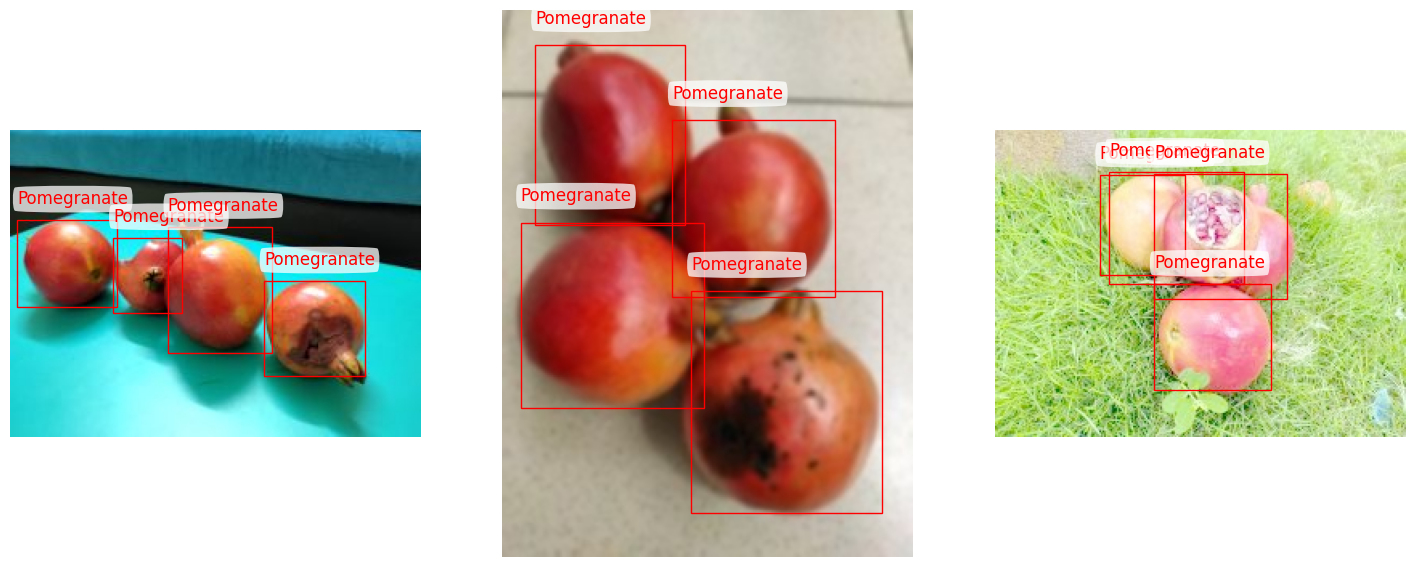

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as T
import torch

# List of image paths you want to display
img_paths = [
    r"val\images\0ef918f6-IMG20200728183127_01.jpg",
    r"val\images\aug_1_bfaf2f55-IMG20200728142629.jpg",
    r"val\images\aug_26_f633dfab-IMG20200728125136.jpg"
    
]

# Create a new figure and axis array to display the images
fig, axs = plt.subplots(1, 3, figsize=(18, 12))

coco_names = ['Background', 'Orange', 'Pomegranate']

for ax, img_path in zip(axs, img_paths):
    ig = Image.open(img_path)
    transform = T.ToTensor()
    img = transform(ig)

    model.eval()  # Set the model to evaluation mode

    # Make prediction for the given image
    with torch.no_grad():
        pred = model([img])

    # Keep necessary information
    bboxes, labels, scores = pred[0]['boxes'], pred[0]['labels'], pred[0]['scores']

    # Number of bounding boxes to keep
    num = min(len(bboxes), 4)  

    img_permuted = img.permute(1, 2, 0).numpy()
    ax.imshow(img_permuted)

    for i in range(num):
        x1, y1, x2, y2 = bboxes[i].numpy().astype('int')
        class_name = coco_names[labels.numpy()[i]]

        # Create a Rectangle patch for the bounding box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Place the class name above the bounding box
        ax.text(x1, y1-10, class_name, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none', boxstyle='round4'))

    # Hide axes for this subplot
    ax.axis('off')

plt.savefig(r"Output_images\Pomegranate_val.png", bbox_inches='tight', pad_inches=0.1)

plt.show()


# Orange Plots

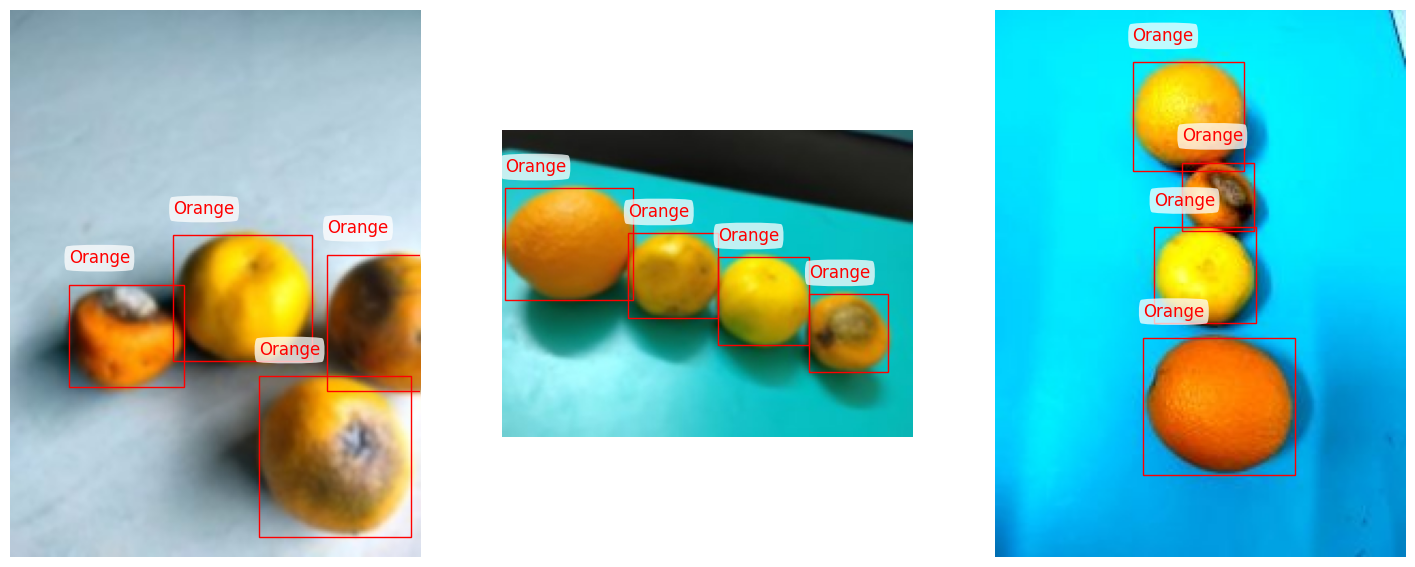

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as T
import torch

# List of image paths you want to display
img_paths = [
    r"val\images\aug_25_3a50e4d3-IMG20200729175023_01.jpg",
    r"val\images\aug_23_2b55b5bd-IMG20200728190318.jpg",
    r"val\images\aug_40_a1f86e80-IMG20200728190342.jpg"
    
]

# Create a new figure and axis array to display the images
fig, axs = plt.subplots(1, 3, figsize=(18, 12))

coco_names = ['Background', 'Orange', 'Pomegranate']

for ax, img_path in zip(axs, img_paths):
    ig = Image.open(img_path)
    transform = T.ToTensor()
    img = transform(ig)

    model.eval()  # Set the model to evaluation mode

    # Make prediction for the given image
    with torch.no_grad():
        pred = model([img])

    # Keep necessary information
    bboxes, labels, scores = pred[0]['boxes'], pred[0]['labels'], pred[0]['scores']

    # Number of bounding boxes to keep
    num = min(len(bboxes), 4)  # We take a minimum of 5 or the actual number of bboxes

    img_permuted = img.permute(1, 2, 0).numpy()
    ax.imshow(img_permuted)

    for i in range(num):
        x1, y1, x2, y2 = bboxes[i].numpy().astype('int')
        class_name = coco_names[labels.numpy()[i]]

        # Create a Rectangle patch for the bounding box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Place the class name above the bounding box
        ax.text(x1, y1-10, class_name, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none', boxstyle='round4'))

    # Hide axes for this subplot
    ax.axis('off')

plt.savefig(r"Output_images\Orange_val.png", bbox_inches='tight', pad_inches=0.1)

plt.show()

# TRY MODEL IN TEST DATASET IMAGES

Although performance metrics on the training and validation sets give us an idea of the model's accuracy, running the model on a test dataset provides the ultimate measure of how well the model generalizes to new, unseen data.By implementing a complete pipeline to run the trained model on test data and visualize its predictions, we're ensuring that the model meets the standards for accuracy, reliability, and interpretability before it is deployed in a real-world application.

In addition, visual inspection of the test set predictions enables us to assess not just the quantitative performance (like accuracy or F1-score), but also the qualitative aspects. It helps in understanding how the model's predictions correspond to real-world scenarios, where the stakes could be high.

## First we define the Test Dataset Class and create the DataLoader

The TestDataset reads RGB images from a given folder and optionally applies transformations like resizing and normalization.After the custom dataset, a DataLoader is created to efficiently feed this data during testing. The DataLoader uses a batch size of 1 and no shuffling (since it's for testing).

In [26]:
class TestDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = os.listdir(image_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Create dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((800, 800)),  # Resize to the same size as during training
    transforms.ToTensor()
])

test_data = TestDataset(r"C:\Users\gkris\Machine_learning\Kris_model_5_elements\test\images", transform=transform)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)


## Set Model to Evaluation Mode and run predictions
The code switches the model to evaluation mode using model.eval(). This is necessary as some layers like dropout and batch normalization behave differently during training and evaluation. After that the model is run on each image from the test dataset, and the output predictions are stored in the test_predictions list.

In [27]:
model.eval()  # Switch to evaluation mode

test_predictions = []

with torch.no_grad():
    for images in test_data_loader:
        # As DataLoader will wrap the single return into a batch, you need to unpack it.
        images = images[0]
        
        # Run model, model returns a list of dictionaries, one for each image in the batch
        predictions_list = model([images])
        
        # Since there's only one image in the batch, select the first dictionary
        predictions = predictions_list[0]
        
        # Convert tensor predictions to numpy arrays for easier handling
        predictions = {key: value.cpu().numpy() for key, value in predictions.items()}
        
        test_predictions.append(predictions)


## Visualize Results

## Pomegranate

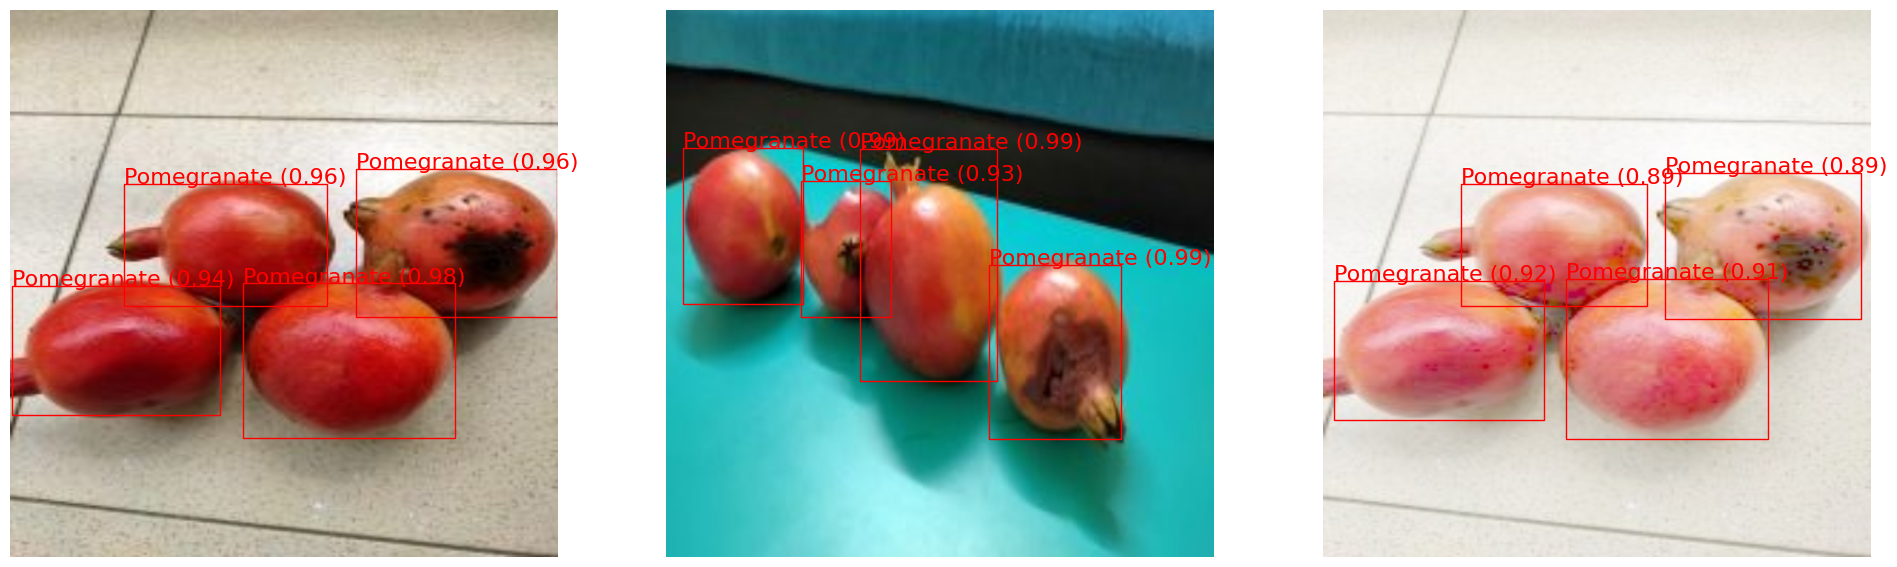

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Define your three test image paths
img_paths = [
    r"test\images\aug_12_cd5c0252-IMG20200728142631.jpg",
    r"test\images\aug_24_6908fb45-IMG20200728183127.jpg",
    r"test\images\aug_26_cd5c0252-IMG20200728142631.jpg",
]

fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # Create a figure with 3 subplots

# Prepare the transformation
transform = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
])

# Your class names
coco_names = ['Background', 'Orange', 'Pomegranate']

# Iterate over each subplot and image path
for ax, img_path in zip(axs, img_paths):
    # Read, transform, and normalize the image
    image = Image.open(img_path).convert("RGB")
    image = transform(image)

    # Run the image through the model
    model.eval()
    with torch.no_grad():
        prediction = model([image])[0]

    # Get the bounding boxes, labels, and scores
    boxes, labels, scores = prediction['boxes'], prediction['labels'], prediction['scores']

    # Get top 5 indices based on scores
    top5_idx = scores.argsort(descending=True)[:4]

    # Convert the image back to a PIL Image and plot it
    ax.imshow(T.ToPILImage()(image).convert("RGB"))

    # Draw top 5 bounding boxes
    for idx in top5_idx:
        x1, y1, x2, y2 = boxes[idx]
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"{coco_names[labels[idx]]} ({scores[idx]:.2f})", color='red', fontsize=16)

    ax.axis('off')

plt.savefig(r"Output_images\Pomegranate_test.png", bbox_inches='tight', pad_inches=0.1)

plt.show()


As we can see in the plots made above in some of the images of the test dataset for pomegranate offer compelling evidence of our model's proficiency in object detection. Impressively, the model achieves a prediction confidence score exceeding 85% for these citrus fruits, underscoring its robustness and reliability in detecting pomegranates even within new, previously unseen data. This high level of accuracy suggests that the model is well-tuned for this category and can be considered highly reliable for tasks requiring pomegranate identification and localization.

## Oranges

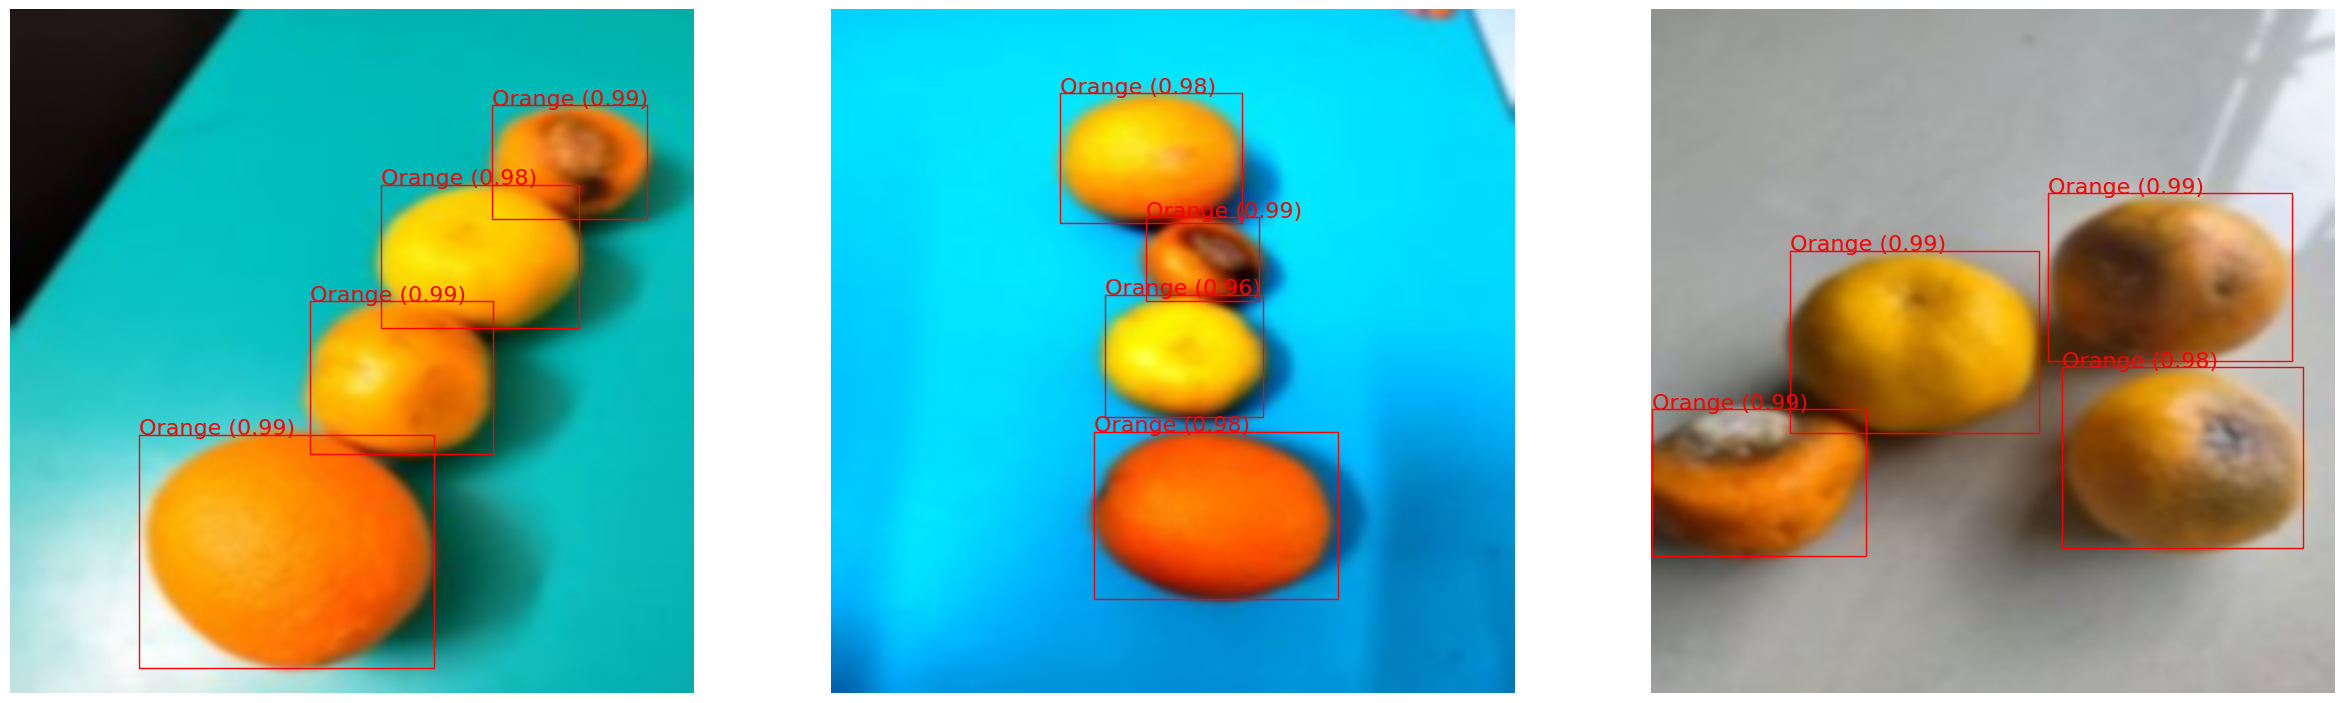

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Define your three test image paths
img_paths = [
    r"test\images\aug_17_6a8333a2-IMG20200728190313.jpg",
    r"test\images\aug_19_4c5b66f8-IMG20200728190342_01.jpg",
    r"test\images\aug_29_19bf3f0b-IMG20200729175022.jpg",
]

fig, axs = plt.subplots(1, 3, figsize=(30, 10))  # Create a figure with 3 subplots

# Prepare the transformation
transform = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
])

# Your class names
coco_names = ['Background', 'Orange', 'Pomegranate']

# Iterate over each subplot and image path
for ax, img_path in zip(axs, img_paths):
    # Read, transform, and normalize the image
    image = Image.open(img_path).convert("RGB")
    image = transform(image)

    # Run the image through the model
    model.eval()
    with torch.no_grad():
        prediction = model([image])[0]

    # Get the bounding boxes, labels, and scores
    boxes, labels, scores = prediction['boxes'], prediction['labels'], prediction['scores']

    # Get top 5 indices based on scores
    top5_idx = scores.argsort(descending=True)[:4]

    # Convert the image back to a PIL Image and plot it
    ax.imshow(T.ToPILImage()(image).convert("RGB"))

    # Draw top 5 bounding boxes
    for idx in top5_idx:
        x1, y1, x2, y2 = boxes[idx]
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"{coco_names[labels[idx]]} ({scores[idx]:.2f})", color='red', fontsize=16)

    ax.axis('off')

plt.savefig(r"Output_images\Orange_test.png", bbox_inches='tight', pad_inches=0.1)

plt.show()


In the case of oranges, the model's performance is also really good. This level of precision suggests that the model remains reliable for applications involving the identification and localization of oranges. 